In [132]:
import cobra.test
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import numpy as np
import seaborn as sns
import os
import math
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.io import save_json_model


### Determine Maintenance energy for each biologically relevant combination of the electron transport system

To do this we will have a set of enzyme combinations to make a unique path that will share electrons between O2 reduction and N2 reduction. Each path will have a different stoichiometry for proton translocation leading to different sucrose per ATP ratio. So given a the experimentally determined maintenance coefficient (mmol of sucrose/ hr/ gCDW) different maintenance rates (ATPM) will be given for each ETS pathway. The assumption that will be made is that a minimizing of the ATP maintenance is preferred (more on this assumption later). So each ETS path will have a corresponding ATPM flux in each O2 concentration we can then use this ATPM flux (determined from experimental maintenance coefficient) and make it a constant in a simulation with experimentally determined sucrose uptake rate. With the given sucrose uptake rate and the determined ATPM flux we can test how similar the predicted growth is to the experimental growth. 

By looking at the branched diagram below we can divide the ETS network into 8 paths each with the NADHI/NADHII, RNF/FIX, or Cytbd/cytco pairs. 



<img src="Images/branched.PNG" width=800 height=400 />

For nomenclature we will simplify names as follows: 

- **NADH5**- NADH dehydrogenase II (uncoupled) = NII
- **NADH6**- NADH dehyrdogenase I (coupled) = NI
- **FIX**- Fix = F
- **RNF**- Rnf = R
- **CYTBDpp**- Cytochrome bd = BD
- **CYOO2pp**- Cytochrome c pathways (complex III and IV) = CO

So there are 8 combinations 

- NII_BD_F
- NII_CO_F
- NII_BD_R
- NII_CO_R
- NI_BD_F
- NI_CO_F
- NI_BD_R
- NI_CO_R

*We know that there will be overlap in total H+/e- translocated and that some of these combinations are not biologically relevant (NII CO) but looking at all combinations allow for interpretations of "inbetween" states*

Now to add some confusion to nomenclature we will have to knockout the enzymes not in the path. So we will make a list of reaction ids of enzymes not in the path. 

In [133]:
#reaction ids not in pathway then "name" of pathway
NII_BD_F = ["NADH6", "CYOO2pp", "RNF", "NII_BD_F"]
NII_CO_F = ["NADH6", "CYTBDpp", "RNF", "NII_CO_F"]
NII_BD_R = ["NADH6", "CYOO2pp", "FIX", "NII_BD_R"]
NII_CO_R = ["NADH6", "CYTBDpp", "FIX", "NII_CO_R"]
NI_BD_F = ["NADH5", "CYOO2pp", "RNF", "NI_BD_F"]
NI_CO_F = ["NADH5", "CYTBDpp", "RNF", "NI_CO_F"] 
NI_BD_R = ["NADH5", "CYOO2pp", "FIX", "NI_BD_R"]
NI_CO_R= ["NADH5", "CYTBDpp", "FIX", "NI_CO_R"]

all_paths = [NII_BD_F,
                NII_CO_F, 
                NII_BD_R,
                NII_CO_R,
                NI_BD_F,
                NI_CO_F,
                NI_BD_R,
                NI_CO_R]

In [134]:
#check names
all_paths

[['NADH6', 'CYOO2pp', 'RNF', 'NII_BD_F'],
 ['NADH6', 'CYTBDpp', 'RNF', 'NII_CO_F'],
 ['NADH6', 'CYOO2pp', 'FIX', 'NII_BD_R'],
 ['NADH6', 'CYTBDpp', 'FIX', 'NII_CO_R'],
 ['NADH5', 'CYOO2pp', 'RNF', 'NI_BD_F'],
 ['NADH5', 'CYTBDpp', 'RNF', 'NI_CO_F'],
 ['NADH5', 'CYOO2pp', 'FIX', 'NI_BD_R'],
 ['NADH5', 'CYTBDpp', 'FIX', 'NI_CO_R']]

Now we want to write a function that can determine the ATPM flux over under multiple different $O_2$ concentrations for each pathway. First lay out the maintenance coefficients from Khula and Oelze 1988 (in data folder): "Khula_Oelze_1988_Table_1.csv"

In [135]:
#Add the maintenance coefficent values from Khula et al converted into mmol of sucrose / hr / gCDW 
Maintenance_coefficient = [0.9, 4.4, 6.2, 7, 8]

#Add the coresponding O2 concentration for labeling
O2_concentration = [12, 48, 108, 144, 192]

In [136]:
def determine_maintenance(Model, rxn_path, lb, ub, interval, maint_coef, O2_conc, path_name):
    """
    This takes a cobra model in json format and knockouts reactions (sets bounds to zero) of interest 
    listed in rxn_path. For this version there is only three reactions to be changed.

    The function iterates over different experimentally determined maintenance coefficients 
    (mmol of substrate/ hr/ gCDW) and predicts a ATP maintenance rates by creating a array of testable
    lower bounds for ATPM. When the growth rate is zero the ATPM flux matches the given
    maintenance coefficient in (maint_coef) resulting in the ATPM for that condition (O2_conc).

    Variables lb, ub, and interval are to be played with. If expected to have large maintenance then set 
    ub to a large number (never exceed 1000). The higher the interval the more accurate the ATPM rate when
    zero but also increases the iterations of the function.

    """

    print(path_name)
    # create array of testable bounds
    ATPM_bound = np.linspace(lb, ub, interval).tolist()
    ATPM_bound.reverse()
    ATPM_bound_value = []
    Growth_rate = []
    Main_co = []

    for j in maint_coef:
        model = cobra.io.load_json_model(Model)

        # Make sure glucose is set to zero
        model.reactions.get_by_id("EX_glc__D_e").lower_bound = 0
        model.reactions.get_by_id("EX_glc__D_e").upper_bound = 0

        # Make sure model is diazotrophic
        model.reactions.get_by_id("EX_nh4_e").lower_bound = 0
        model.reactions.get_by_id("EX_nh4_e").upper_bound = 0

        # set the flux to zero of corresponding reactions in pathway of interest
        model.reactions.get_by_id(rxn_path[0]).upper_bound = 0
        model.reactions.get_by_id(rxn_path[0]).lower_bound = 0

        model.reactions.get_by_id(rxn_path[1]).upper_bound = 0
        model.reactions.get_by_id(rxn_path[1]).lower_bound = 0

        model.reactions.get_by_id(rxn_path[2]).upper_bound = 0
        model.reactions.get_by_id(rxn_path[2]).lower_bound = 0

        # Set sucrose uptake to maintenance coefficient
        model.reactions.get_by_id("EX_sucr_e").lower_bound = -j
        model.reactions.get_by_id("EX_sucr_e").upper_bound = -j

        # save model if needed for extra analysis

        save_json_model(model,'../Data/Models/Maintenance_Models/MaintenanceRate_sucrose_{}_O2_{}.json'.format(j, path_name))

        # This takes some time so nice to know what step its on
        print(f'Running maintenance coefficient {j}')

        for i in ATPM_bound:
            model.reactions.get_by_id("ATPM").upper_bound = 1000
            model.reactions.get_by_id("ATPM").lower_bound = i
            solution = model.optimize()
            ATPM_bound_value.append(i)
            Growth_rate.append(solution.objective_value)
            Main_co.append(j)

    # Make data frame
    df = pd.DataFrame({
        'Maintenance_coefficient': Main_co,
        'ATPM_bound_value': ATPM_bound_value,
        'Growth_Rate': Growth_rate})

    # add column with pathway label
    df.insert(0, 'ETS_path', path_name)

    # label row with oxygen concentration (I am sure there is a better way to do this)
    def o2_label(n):
        if n['Maintenance_coefficient'] == 0.9:
            return 12
        elif n['Maintenance_coefficient'] == 4.4:
            return 48
        elif n['Maintenance_coefficient'] == 6.2:
            return 108
        elif n['Maintenance_coefficient'] == 7.0:
            return 144
        else:
            return 192

    df['O2_concentration'] = df.apply(o2_label, axis=1)

    # save to csv with details on which path an which conditions were used

    df.to_csv('../Data/Maintenance_rates/MaintenanceRate_sucrose_O2_{}.csv'.format(path_name), sep=',', index=False)

    # output maintenance rate by determining where each condition hits zero
    print('Maintenance rates for pathway {} :'.format(path_name))
    df_12_limit = df[(df.Growth_Rate == 0) & (df.O2_concentration == 12)]
    print(f' ATP Maintenance at 12 \u03BC Mol of O2 is:{df_12_limit["ATPM_bound_value"].iloc[-1]}')
    df_48_limit = df[(df.Growth_Rate == 0) & (df.O2_concentration == 48)]
    print(f' ATP Maintenance at 48 \u03BC Mol of O2 is:{df_48_limit["ATPM_bound_value"].iloc[-1]}')
    df_108_limit = df[(df.Growth_Rate == 0) & (df.O2_concentration == 108)]
    print(f' ATP Maintenance at 108 \u03BC Mol of O2 is:{df_108_limit["ATPM_bound_value"].iloc[-1]}')
    df_144_limit = df[(df.Growth_Rate == 0) & (df.O2_concentration == 144)]
    print(f' ATP Maintenance at 144 \u03BC Mol of O2 is:{df_144_limit["ATPM_bound_value"].iloc[-1]}')
    df_192_limit = df[(df.Growth_Rate == 0) & (df.O2_concentration == 192)]
    print(f' ATP Maintenance at 192 \u03BC Mol of O2 is: {df_192_limit["ATPM_bound_value"].iloc[-1]}')


In [137]:
#check that it works for a single pathway also this should be the largest one so it can give us an estimation of max bound
determine_maintenance("../Data/Models/iAA1300_C.json", NI_CO_F, 0, 750, 100, Maintenance_coefficient, O2_concentration,  "NI_CO_F")

NI_CO_F
Running maintenance coefficient 0.9


C:\Users\alexa\anaconda3\envs\Metabolic_models\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Running maintenance coefficient 4.4
Running maintenance coefficient 6.2
Running maintenance coefficient 7
Running maintenance coefficient 8
Maintenance rates for pathway NI_CO_F :
 ATP Maintenance at 12 μ Mol of O2 is:53.03030303030303
 ATP Maintenance at 48 μ Mol of O2 is:250.0
 ATP Maintenance at 108 μ Mol of O2 is:348.4848484848485
 ATP Maintenance at 144 μ Mol of O2 is:393.93939393939394
 ATP Maintenance at 192 μ Mol of O2 is: 446.969696969697


In [152]:
#iterate of all pathways 

for ETS_path in all_paths:
       determine_maintenance("../Data/Models/iAA1300_C.json", ETS_path, 0, 500, 2000, Maintenance_coefficient, O2_concentration, ETS_path[3])

NII_BD_F
Running maintenance coefficient 0.9


C:\Users\alexa\anaconda3\envs\Metabolic_models\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Running maintenance coefficient 4.4
Running maintenance coefficient 6.2
Running maintenance coefficient 7
Running maintenance coefficient 8
Maintenance rates for pathway NII_BD_F :
 ATP Maintenance at 12 μ Mol of O2 is:16.258129064532266
 ATP Maintenance at 48 μ Mol of O2 is:78.78939469734868
 ATP Maintenance at 108 μ Mol of O2 is:110.80540270135069
 ATP Maintenance at 144 μ Mol of O2 is:125.06253126563283
 ATP Maintenance at 192 μ Mol of O2 is: 143.07153576788394
NII_CO_F
Running maintenance coefficient 0.9


C:\Users\alexa\anaconda3\envs\Metabolic_models\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Running maintenance coefficient 4.4
Running maintenance coefficient 6.2
Running maintenance coefficient 7
Running maintenance coefficient 8
Maintenance rates for pathway NII_CO_F :
 ATP Maintenance at 12 μ Mol of O2 is:37.768884442221115
 ATP Maintenance at 48 μ Mol of O2 is:184.3421710855428
 ATP Maintenance at 108 μ Mol of O2 is:259.62981490745375
 ATP Maintenance at 144 μ Mol of O2 is:293.14657328664333
 ATP Maintenance at 192 μ Mol of O2 is: 334.9174587293647
NII_BD_R
Running maintenance coefficient 0.9


C:\Users\alexa\anaconda3\envs\Metabolic_models\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Running maintenance coefficient 4.4
Running maintenance coefficient 6.2
Running maintenance coefficient 7
Running maintenance coefficient 8
Maintenance rates for pathway NII_BD_R :
 ATP Maintenance at 12 μ Mol of O2 is:16.258129064532266
 ATP Maintenance at 48 μ Mol of O2 is:78.78939469734868
 ATP Maintenance at 108 μ Mol of O2 is:110.80540270135069
 ATP Maintenance at 144 μ Mol of O2 is:125.06253126563283
 ATP Maintenance at 192 μ Mol of O2 is: 143.07153576788394
NII_CO_R
Running maintenance coefficient 0.9


C:\Users\alexa\anaconda3\envs\Metabolic_models\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Running maintenance coefficient 4.4
Running maintenance coefficient 6.2
Running maintenance coefficient 7
Running maintenance coefficient 8
Maintenance rates for pathway NII_CO_R :
 ATP Maintenance at 12 μ Mol of O2 is:37.768884442221115
 ATP Maintenance at 48 μ Mol of O2 is:184.3421710855428
 ATP Maintenance at 108 μ Mol of O2 is:259.62981490745375
 ATP Maintenance at 144 μ Mol of O2 is:293.14657328664333
 ATP Maintenance at 192 μ Mol of O2 is: 334.9174587293647
NI_BD_F
Running maintenance coefficient 0.9


C:\Users\alexa\anaconda3\envs\Metabolic_models\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Running maintenance coefficient 4.4
Running maintenance coefficient 6.2
Running maintenance coefficient 7
Running maintenance coefficient 8
Maintenance rates for pathway NI_BD_F :
 ATP Maintenance at 12 μ Mol of O2 is:28.76438219109555
 ATP Maintenance at 48 μ Mol of O2 is:140.07003501750876
 ATP Maintenance at 108 μ Mol of O2 is:197.3486743371686
 ATP Maintenance at 144 μ Mol of O2 is:222.8614307153577
 ATP Maintenance at 192 μ Mol of O2 is: 254.62731365682842
NI_CO_F
Running maintenance coefficient 0.9


C:\Users\alexa\anaconda3\envs\Metabolic_models\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Running maintenance coefficient 4.4
Running maintenance coefficient 6.2
Running maintenance coefficient 7
Running maintenance coefficient 8
Maintenance rates for pathway NI_CO_F :
 ATP Maintenance at 12 μ Mol of O2 is:50.275137568784395
 ATP Maintenance at 48 μ Mol of O2 is:245.62281140570286
 ATP Maintenance at 108 μ Mol of O2 is:346.17308654327167
 ATP Maintenance at 144 μ Mol of O2 is:390.94547273636823
 ATP Maintenance at 192 μ Mol of O2 is: 446.72336168084047
NI_BD_R
Running maintenance coefficient 0.9


C:\Users\alexa\anaconda3\envs\Metabolic_models\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Running maintenance coefficient 4.4
Running maintenance coefficient 6.2
Running maintenance coefficient 7
Running maintenance coefficient 8
Maintenance rates for pathway NI_BD_R :
 ATP Maintenance at 12 μ Mol of O2 is:28.76438219109555
 ATP Maintenance at 48 μ Mol of O2 is:140.07003501750876
 ATP Maintenance at 108 μ Mol of O2 is:197.3486743371686
 ATP Maintenance at 144 μ Mol of O2 is:222.8614307153577
 ATP Maintenance at 192 μ Mol of O2 is: 254.62731365682842
NI_CO_R
Running maintenance coefficient 0.9


C:\Users\alexa\anaconda3\envs\Metabolic_models\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Running maintenance coefficient 4.4
Running maintenance coefficient 6.2
Running maintenance coefficient 7
Running maintenance coefficient 8
Maintenance rates for pathway NI_CO_R :
 ATP Maintenance at 12 μ Mol of O2 is:50.275137568784395
 ATP Maintenance at 48 μ Mol of O2 is:245.62281140570286
 ATP Maintenance at 108 μ Mol of O2 is:346.17308654327167
 ATP Maintenance at 144 μ Mol of O2 is:390.94547273636823
 ATP Maintenance at 192 μ Mol of O2 is: 446.72336168084047


In [153]:
#lets reupload the files and merge to pullout the above infromation to make a table (also alows us to comment out the above functions)
import glob

path = r'../Data/Maintenance_rates' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

all_paths_df = pd.concat(li, axis=0, ignore_index=True)

In [154]:
#make path and O2 concentration variable
all_paths_df["group"] = all_paths_df["ETS_path"].astype(str) + "_" + all_paths_df["O2_concentration"].astype(str)
#select only zero growth rates
all_paths_df_0 = all_paths_df[all_paths_df["Growth_Rate"] == 0]

#find minimum ATPM_bound for each group 
all_paths_df_min = all_paths_df_0.groupby('group')['ATPM_bound_value'].min()

#This gives a series with the ATPM number and group as the index will merge with label colums
all_paths_df_label = all_paths_df_0[['ETS_path', 'O2_concentration', 'group']]
all_paths_df_merge = pd.merge(all_paths_df_label, all_paths_df_min, on = 'group').drop_duplicates()
all_paths_df_merge.reset_index(drop=True, inplace=True)
all_paths_df_merge.to_csv("../Data/Maintenance_rates/Maintenance_rates_pred.csv")


#lets sort with minimum ATPM_bound to take a look
all_paths_df_merge.sort_values(ascending=True, by = 'ATPM_bound_value')



,ETS_path,O2_concentration,group,ATPM_bound_value
0,NII_BD_F,12,NII_BD_F_12,16.258129
5,NII_BD_R,12,NII_BD_R_12,16.258129
25,NI_BD_R,12,NI_BD_R_12,28.764382
20,NI_BD_F,12,NI_BD_F_12,28.764382
10,NII_CO_F,12,NII_CO_F_12,37.768884
15,NII_CO_R,12,NII_CO_R_12,37.768884
35,NI_CO_R,12,NI_CO_R_12,50.275138
30,NI_CO_F,12,NI_CO_F_12,50.275138
6,NII_BD_R,48,NII_BD_R_48,78.789395
1,NII_BD_F,48,NII_BD_F_48,78.789395


So the goal here is to minimize ATPM rate because 1) this is already very high rate in most conditions 2) The ETS path with the most decoupling of the ATP/O ratio will lead to the smallest ATPM rate. Here we can see that there are similar patterns when combining enzymes in the path and as expected the "respiratory protection" (NII_BD) has the lowest in each condition. But looking at this chart is confusing so lets put it in a simple bar chart. 

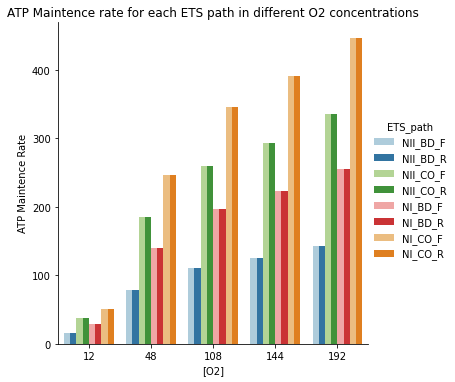

In [155]:
ax = sns.catplot( x = 'O2_concentration', y = 'ATPM_bound_value', hue = 'ETS_path', data = all_paths_df_merge, kind = 'bar', palette = "Paired")
plt.title( 'ATP Maintence rate for each ETS path in different O2 concentrations')
ax.set_axis_labels('[O2]','ATP Maintence Rate')


Here we can see some overall patterns of the different paths 

Something is up with NI_BD_F as it shouldnt atch the NI_CO_R 

NameError: name 'model' is not defined

In [ ]:
#check out NI_CO models 
#load data 
model_NI_BD_F = cobra.io.load_json_model('../Data/Models/Maintenance_Models/MaintenanceRate_sucrose_6.2_O2_NI_BD_F.json')
Builder(model = model_NI_BD_F,
                 map_json = '../Data/Escher/Maps/Full_metabolism_Av.json',
                  reaction_data = model_NI_BD_F.optimize().fluxes
                      )

In [ ]:
#check out NI_CO models 
#load data 
model_NI_BD_R = cobra.io.load_json_model('../Data/Models/Maintenance_Models/MaintenanceRate_sucrose_6.2_O2_NI_BD_R.json')
Builder(model = model_NI_BD_F,
                 map_json = '../Data/Escher/Maps/Full_metabolism_Av.json',
                  reaction_data = model_NI_BD_R.optimize().fluxes
                      )